# Image2StyleGAN Reproduction

Mount the google drive and download some necessary libraries

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/MyDrive/internship/

/content/gdrive/MyDrive/internship


In [4]:
!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3
!pip install lpips

     |████████████████████████████████| 204kB 2.8MB/s 
     |████████████████████████████████| 112kB 7.3MB/s 
     |████████████████████████████████| 26.9MB 112kB/s 
     |████████████████████████████████| 61kB 1.9MB/s 


## Checking the pretrained model
    
We will load the necessary libraries to run the pretrained version

In [5]:
# First set the base dir
!ls
!ls stuff/pretrained_models/

checking_perceptuals.ipynb  latent_space_P.ipynb    torch_utils
dnnlib			    semantic_editing.ipynb
embedding_version.ipynb     stuff
ffhq.pkl


In [6]:
# Import the needed libraries
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import torch.nn as nn
import torch
from torchvision import models, transforms
import torch.optim as optim
from PIL import Image
import os
from torchvision.utils import save_image, make_grid
import numpy as np
import lpips
import warnings
warnings.filterwarnings("ignore")

In [7]:
!ls stuff/data/

expression01.png  sample02.png	sample05.png  sample08.png  sample11.png
expression02.png  sample03.png	sample06.png  sample09.PNG
sample01.png	  sample04.png	sample07.png  sample10.PNG


In [8]:
# Setting global attributes
RESOLUTION = 1024
#DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ITERATIONS = 1500
SAVE_STEP = 100

# OPTIMIZER
LEARNING_RATE = 0.01
BETA_1 = 0.9
BETA_2 = 0.999
EPSILON = 1e-8

# GENERATOR
G_LAYERS = 18
Z_SIZE = 512

# IMAGE TO EMBED
#PATH_IMAGE = "stuff/data/expression02.png"
PATH_IMAGE = "stuff/data/sample03.png"
basename=os.path.basename(os.path.normpath(PATH_IMAGE)).split(".")[0]
SAVING_DIR = 'stuff/results/synthetic_images/'

In [9]:
DEVICE

device(type='cuda', index=0)

## Loadding Pretrained Model
Load the pretrained model using the pickle file. I need the libraries `dnnlib` and `torch_utils` to load this model.

It does not need source code for the networks themselves — their class definitions are loaded from the pickle via `torch_utils.persistence`.


In [10]:
PRETRAINED_MODEL = "stuff/pretrained_models/ffhq.pkl"

with open(PRETRAINED_MODEL, 'rb') as f:
    G = pickle.load(f)['G_ema'].to(DEVICE)  # torch.nn.Module

The pickle contains three networks. `'G'` and `'D'` are instantaneous snapshots taken during training, and `'G_ema'` represents a moving average of the generator weights over several training steps. The networks are regular instances of `torch.nn.Module`, with all of their parameters and buffers placed on the CPU at import and gradient computation disabled by default.

The generator consists of two submodules, `G.mapping` and `G.synthesis`, that can be executed separately. They also support various additional options:

```.python
w = G.mapping(z, c, truncation_psi=0.5, truncation_cutoff=8)
img = G.synthesis(w, noise_mode='const', force_fp32=True)
```

Please refer to [`generate.py`](./generate.py), [`style_mixing.py`](./style_mixing.py), and [`projector.py`](./projector.py) for further examples.

From G we need to extract the `mapping` and the `synthesis` modules.

## Loss Function

The embedding algorithm selects a random initial latent code and optimize it using gradient descent. To do that, the authors defines a loss function based on VGG-16 perceptual loss and the pixel-wise MSE loss:

$$ w^{*}=\min _{w} L_{\text {percept }}(G(w), I)+\frac{\lambda_{m s e}}{N}\|G(w)-I\|_{2}^{2} $$

### VGG-16 perceptual loss
For the perceptual loss term $L_{\text {percept }}(\cdot)$

$$ L_{\text {percept }}\left(I_{1}, I_{2}\right)=\sum_{j=1}^{4} \frac{\lambda_{j}}{N_{j}}\left\|F_{j}\left(I_{1}\right)-F_{j}\left(I_{2}\right)\right\|_{2}^{2} $$

where $I_{1}, I_{2} \in \mathbb{R}^{n \times n \times 3}$ are the input images, $F_j$ is the feature output of VGG-16 layer `conv1_1`, `conv1_2`, `conv3_2` and `conv4_2` respectively, $N_j$ is the number of scalars in the $j^{th}$ layer output, $\lambda_j = 1$ for all js are empiracally obtained for good performance.

In [11]:
# First explored the vgg16 module to check the convolutional layers
models.vgg16(pretrained=True).features

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

We need to extract the feature maps after convolutional layers `conv1_1`, `conv1_2`, `conv3_2` and `conv4_2` respectively. 

* `conv1_1` : block 1 - convolution 1
* `conv1_2` : block 1 - convolution 2
* `conv3_2` : block 3 - convolution 2
* `conv4_2` : block 4 - convolution 2

In the previous pytorch module, these convolutional layers corresponds to indexes: 0 2 12 19, but we need to include the ReLu activation and all the previous layers. In this way, we have:

| indexes of layers | number of layers |
|:-----------------:|:----------------:|
|       [0,1]       |         2        |
|       [0,3]       |         4        |
|       [0,13]      |        14        |
|       [0,20]      |        21        |

Then we define a module that extract the respective feature maps:

In [12]:
# Defining the VGG16 Perceptual Network

class PerceptualVGG16(torch.nn.Module):
    def __init__(self, requires_grad=False, n_layers=[2, 4, 14, 21]):
        super(PerceptualVGG16, self).__init__()
        
        # Dowsampling according to input of ImageNet 256x256
        self.upsample2d = torch.nn.Upsample(scale_factor=256/RESOLUTION, mode='bilinear')

        # Get the pretrained vgg16 model
        vgg_pretrained_features = models.vgg16(pretrained=True).features

        self.slice0 = torch.nn.Sequential()
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        
        # [0,1] layers indexes
        for x in range(n_layers[0]):  
            self.slice0.add_module(str(x), vgg_pretrained_features[x])\
            
        # [2, 3] layers indexes
        for x in range(n_layers[0], n_layers[1]):  # relu1_2
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        
        # [4, 13] layers indexes
        for x in range(n_layers[1], n_layers[2]): # relu3_2
            self.slice2.add_module(str(x), vgg_pretrained_features[x])

        # [14, 20] layers indexes
        for x in range(n_layers[2], n_layers[3]):# relu4_2
            self.slice3.add_module(str(x), vgg_pretrained_features[x])

        # Setting the gradients to false
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad=False
                
    def forward(self, x):
        upsample = self.upsample2d(x)
        
        h0 = self.slice0(upsample)
        h1 = self.slice1(h0)
        h2 = self.slice2(h1)
        h3 = self.slice3(h2)

        return h0, h1, h2, h3

Now we define our loss functions, and the function that will measure the loss

In [13]:
# Pixel-Wise MSE Loss
MSE_Loss = nn.MSELoss(reduction="mean")

# VGG-16 perceptual loss
perceptual_net_vgg = PerceptualVGG16(n_layers=[2,4,14,21]).to(DEVICE)

### LPIPS perceptual loss

In this reproduction, I propose to use another perceptual loss, which has demonstrated a better performance in term of perceptual metrics according to the following article [The Unreasonable Effectiveness of Deep Features as a Perceptual Metric](https://arxiv.org/abs/1801.03924). The metric was named **Learned Perceptual Image Patch Similarity**(LPIPS). 

This metric measure a distance between a reference and synthetic image using the intermediate activated feature maps of a common network $\mathcal{F}$. However, in this case the authors following the next steps:

1. Extract  feature  stack  from $L$ layers 
2. Unit-normalize  in the  channel  dimension, designated as $\hat{y}^l, \hat{y}^l_0 \in \mathbb{R}^{H_l \times W_l \times Cl} $ for layer $l$. 
3. Scale the activations channel-wise by vector $w_l \in \mathbb{R}^{C_l}$
4. Compute the $l2$ distance.
5. Finally average spatially and sum channel-wise. 

The previous process leave us to

$$ d\left(x, x_{0}\right)=\sum_{l} \frac{1}{H_{l} W_{l}} \sum_{h, w}\left\|w_{l} \odot\left(\hat{y}_{h w}^{l}-\hat{y}_{0 h w}^{l}\right)\right\|_{2}^{2} $$

Note: Additionally this perceptual metric could be using patches of the reference and synthesis images, instead of the completed image.


In [41]:
# For get this perceptual loss, I used the library provided by the authors
# I will check this perceptual metric using two different networks vgg and alex
perceptual_lpips_vgg = lpips.LPIPS(net='vgg').to(DEVICE)

perceptual_lpips_alex = lpips.LPIPS(net='alex').to(DEVICE)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/alex.pth


Then, I defined a function that takes into consideration both metrics for executing some experiments later.

In [15]:
# This functions allow us to calculate the loss using the lpips metric or
# the metric based on the activated feature maps of the VGG16
def calculate_loss(synth_img,original_img,perceptual_net,MSE_Loss, mode = 'lpips'):
    # calculate MSE Loss
    # (lamda_mse/N)*||G(w)-I||^2
    mse_loss = MSE_Loss(synth_img,original_img) 

    # calculate Perceptual Loss

    if 'lpips' in mode:
      perceptual_loss = perceptual_net.forward(original_img,synth_img)
      perceptual_loss = perceptual_loss.squeeze(0).squeeze(0).squeeze(0).squeeze(0)
    else:
      # sum_all (lamda_j / N) * ||F(I1) - F(I2)||^2
      real_0,real_1,real_2,real_3 = perceptual_net(original_img)
      synth_0,synth_1,synth_2,synth_3=perceptual_net(synth_img)

      perceptual_loss=0
      perceptual_loss+=MSE_Loss(synth_0,real_0)
      perceptual_loss+=MSE_Loss(synth_1,real_1)
      perceptual_loss+=MSE_Loss(synth_2,real_2)
      perceptual_loss+=MSE_Loss(synth_3,real_3)

    return mse_loss,perceptual_loss

## Embedding Latent and Optimizer Adam

In the article, the authors mention that they select a random initial latent code and optimize it using gradient descent. In this way, I define our tensor `embedding_latent` with gradients.

The paper also mentions that this embedding_latent can be initialized of different ways. Here, we have three options:

1. w+ all to zero (proposed in this reproduction)
2. w+ $\sim \mathcal{U}[-1,1]$ (random)
3. w+ $ = \bar{w}$ (the meant latent vector)

Then, I define the adam optimizer with the specification of the paper.

In [16]:
n_samples = 5e5
def get_mean_latent():
  z = torch.randn((int(n_samples), 512), device=DEVICE)
  batch_size = int(1e5)

  w_mean = torch.zeros((1,18,512),requires_grad=True,device=DEVICE)
  for i in range(int(n_samples/batch_size)):
    w = G.mapping(z[i*batch_size:(i+1)*batch_size,:], None)
    w = torch.sum(w, dim = 0).unsqueeze(0)
    w_mean = w_mean + w

  w_mean = w_mean / n_samples

  return w_mean.clone().detach().requires_grad_(True)

In [17]:
# the embeding latent over the w+ laten spece
# the extended latent w+ contains array of size 512
# correspongin to the 18 layers in the generator.

# embedding to the mean latent vector
embedding_latent = get_mean_latent()

# embedding initializer to all zero
#embedding_latent = torch.zeros((1,18,512),requires_grad=True,device=DEVICE)

# embedding intializer to uniform in [-1,1]
#embedding_latent = torch.cuda.FloatTensor(1,18,512).uniform_(-1,1).requires_grad_()

# define the optimizer
optimizer = optim.Adam({embedding_latent},lr=LEARNING_RATE,betas=(BETA_1,BETA_2),eps=EPSILON)

Setting up PyTorch plugin "bias_act_plugin"... Done.


## Preparing Data

Should I peform any preproccesing to the the images according to the paper? Here, I checked the reference image and the first synthetic image. We comprobe that the synthetic image is in the range $[-1,1]$. Then, we will load our reference image in the same way.

In [18]:
img=lpips.im2tensor(lpips.load_image(PATH_IMAGE))
img=img.to(DEVICE)
print("Size: ", img.size())
print("Max: ", torch.max(img))
print("Min: ", torch.min(img))

Size:  torch.Size([1, 3, 1024, 1024])
Max:  tensor(0.9922, device='cuda:0')
Min:  tensor(-1., device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


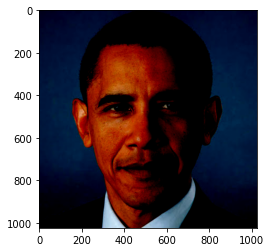

In [19]:
plt.imshow(img.to('cpu').squeeze(0).permute(1, 2, 0))

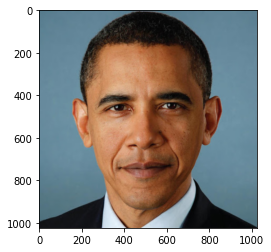

In [20]:
# To plot the image I need to move to [0,1] interval
tmp_img = (img + 1.0) / 2.0
plt.imshow(tmp_img.to('cpu').squeeze(0).permute(1, 2, 0))

In [21]:
# checking the min and max of the generate image
synth_img = G.synthesis(embedding_latent, noise_mode='const', force_fp32=True)
print("Size: ",synth_img.size())
print("Max: ", torch.max(synth_img))
print("Min: ", torch.min(synth_img))

Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Size:  torch.Size([1, 3, 1024, 1024])
Max:  tensor(0.8761, device='cuda:0', grad_fn=<MaxBackward1>)
Min:  tensor(-0.9997, device='cuda:0', grad_fn=<MinBackward1>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


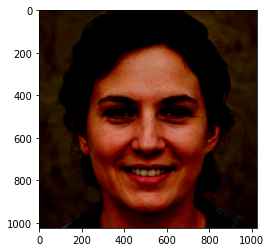

In [22]:
plt.imshow(synth_img.detach().to('cpu').squeeze(0).permute(1, 2, 0))

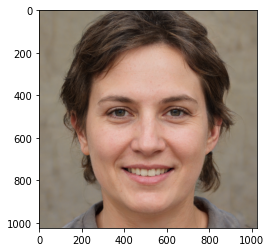

In [23]:
# check what happend when + 1.0 and them divide to 2.0
tmp_img = (synth_img + 1.0) / 2.0
plt.imshow(tmp_img.detach().to('cpu').squeeze(0).permute(1, 2, 0))

## Embedding one image - Experiments


In this process, we try to adjust the embedding_latent in such a way that the synthetic image is the same as the original image. To do that, we follow the net steps: 

1. Feed the pretrained generator with the embedding latent and get the synthetic image
2. Calculate the loss between the synthetic image and the original image
2. Backward the gradients and apply the optimization

Note: additionally we save the generated image, and the current embedding_latent every 100 steps

Before to perform the experiments we define some auxiliar functions

In [24]:
#@title Function to plot loss

# Function to plot the loss per iteration
def plot_loss(losses, save = False):

  plt.figure()
  scale_factor = 5

  plt.title("Loss During Embedding")
  for label, loss in losses.items():
    plt.plot(loss,label=label)
  plt.xlabel("Optimization Steps")
  plt.ylabel("Loss")
  plt.legend()
  

  if save:
    file_dir = os.path.join(SAVING_DIR, "loss_plots/{}_losses_iters_{}.svg".format(basename, str(ITERATIONS).zfill(6)))
    print("Saving: {}".format(file_dir))
    plt.savefig(file_dir)
    
  plt.show()

In [25]:
#@title Function to load latents
# Function to load the latents from the saved .npz file
def load_latents(file_name, display_latents = False):
  latent_embeddings_saved = os.path.join(SAVING_DIR, "latents/"+file_name)

  dictionary = {}
  with open(latent_embeddings_saved, 'rb') as f:
      container = np.load(f)
      
      for iter, latent in container.items():
          dictionary[iter] = latent
          if display_latents:
            print("iter: {} -- latent_code shape: {}".format(iter,latent.shape))
            print(latent[0,0,-5:])
  return dictionary

In [26]:
#@title Function to plot the synthetic image per iterations

def show_images_results(latent_codes, iterations_to_show, subfix = "", save = False):

    saved_iterations = list(latent_codes.keys())
    iterations_to_show_filter = [iter for iter in iterations_to_show if str(iter) in saved_iterations]

    n_images = len(iterations_to_show_filter) + 1
    inches = 4
    fig, axs = plt.subplots(1,n_images ,figsize=(inches * n_images , inches))

    # original image
    with open(PATH_IMAGE,"rb") as f:
        image=Image.open(f)
        axs[0].imshow(image)
        axs[0].set_title('Original')
        axs[0].axis('off')

    # embeddings per iterations
    idx = 1
    for iter in iterations_to_show:
      latent = latent_codes.get(str(iter))

      if latent is not None:
        tensor_latent = torch.tensor(latent).to(DEVICE)
        synth_img = G.synthesis(tensor_latent, noise_mode='const', force_fp32=True)
        synth_img = (synth_img + 1.0) / 2.0
        synth_img = synth_img.detach().to('cpu').squeeze(0).permute(1, 2, 0)       
        axs[idx].imshow(synth_img.clamp(0,1))
        axs[idx].set_title("Iteration: {}".format(str(iter)))
        axs[idx].axis('off')

        idx += 1
      else:
        print("Iteration {} is not stored in file".format(iter))

    if save:
      file_dir = os.path.join(SAVING_DIR, "images/{}_images_{}_to_{}{}.svg".format(
          basename,
          iterations_to_show_filter[0],
          iterations_to_show_filter[-1],
          subfix))
      print("Saving: {}".format(file_dir))
      plt.savefig(file_dir)
            

In [28]:
def run_optimization(img, mode, init, normalization = False):

  # define the init latent
  if init == "w_mean":
    embedding_latent = get_mean_latent()
  elif init == "w_zeros":
    embedding_latent = torch.zeros((1,18,512),requires_grad=True,device=DEVICE)
  elif init == "w_random":
    embedding_latent = torch.cuda.FloatTensor(1,18,512).uniform_(-1,1).requires_grad_()

  # define the type of perceptual net
  if mode == "vgg16":
    perceptual_net = perceptual_net_vgg
  elif mode == "lpips_vgg16":
    perceptual_net = perceptual_lpips_vgg
  elif mode == "lpips_alex":
    perceptual_net = perceptual_lpips_alex

  if normalization:
    img = (img + 1.0) / 2.0

  optimizer = optim.Adam({embedding_latent},lr=LEARNING_RATE,betas=(BETA_1,BETA_2),eps=EPSILON)

  print("Starting Embedding")
  loss_list=[]
  loss_mse=[]
  loss_perceptual=[]
  latent_list = {}
  for i in range(0,ITERATIONS):
      # reset the gradients
      optimizer.zero_grad()

      # get the synthetic image
      synth_img = G.synthesis(embedding_latent, noise_mode='const', force_fp32=True)
      if normalization: 
        synth_img = (synth_img + 1.0) / 2.0
      
      # get the loss and backpropagate the gradients
      mse_loss,perceptual_loss = calculate_loss(synth_img,img, perceptual_net, MSE_Loss, mode = mode)
      loss = mse_loss + perceptual_loss
      loss.backward()

      optimizer.step()

      # store the losses metrics
      loss_list.append(loss.item())
      loss_mse.append(mse_loss.item())
      loss_perceptual.append(perceptual_loss.item())

      # every SAVE_STEP, I store the current latent
      if (i +1) % SAVE_STEP == 0:
          print('iter[%d]:\t loss: %.4f\t mse_loss: %.4f\tpercep_loss: %.4f' % (i+1,  loss.item(), mse_loss.item(), perceptual_loss.item()))
          latent_list[str(i+1)] = embedding_latent.detach().cpu().numpy()

  # store all the embeddings create during optimization in .npz
  path_embedding_latent = os.path.join(SAVING_DIR, 
                                      "latents/{}_latents_iters_{}_step_{}_loss_{}_{}.npz".format(
                                        basename,
                                        str(ITERATIONS).zfill(6),
                                        str(SAVE_STEP).zfill(4), 
                                        mode,
                                        init))
  print("Saving: {}".format(path_embedding_latent))
  np.savez(path_embedding_latent, **latent_list)

  return loss_list

### Initializer Experiments

In this experiment, I want to check what is the appearance of the synthetic image with different initializers in the short term (with few optimization steps).

In [28]:
# I fixed the max iteration to 5000
ITERATIONS = 5000

In [29]:
# VGG-16 perceptual loss
loss_vgg16_w_mean = run_optimization( mode = 'vgg16', init = 'w_mean')

Starting Embedding
iter[100]:	 loss: 3.1962	 mse_loss: 0.0369	percep_loss: 3.1593
iter[200]:	 loss: 2.2530	 mse_loss: 0.0229	percep_loss: 2.2301
iter[300]:	 loss: 1.7554	 mse_loss: 0.0148	percep_loss: 1.7405
iter[400]:	 loss: 1.5439	 mse_loss: 0.0138	percep_loss: 1.5300
iter[500]:	 loss: 1.4227	 mse_loss: 0.0133	percep_loss: 1.4094
iter[600]:	 loss: 1.3467	 mse_loss: 0.0119	percep_loss: 1.3348
iter[700]:	 loss: 1.2720	 mse_loss: 0.0114	percep_loss: 1.2607
iter[800]:	 loss: 1.2187	 mse_loss: 0.0111	percep_loss: 1.2076
iter[900]:	 loss: 1.1707	 mse_loss: 0.0102	percep_loss: 1.1605
iter[1000]:	 loss: 1.1518	 mse_loss: 0.0099	percep_loss: 1.1419
iter[1100]:	 loss: 1.1073	 mse_loss: 0.0095	percep_loss: 1.0978
iter[1200]:	 loss: 1.0844	 mse_loss: 0.0092	percep_loss: 1.0752
iter[1300]:	 loss: 1.0518	 mse_loss: 0.0089	percep_loss: 1.0429
iter[1400]:	 loss: 1.0402	 mse_loss: 0.0087	percep_loss: 1.0315
iter[1500]:	 loss: 1.0124	 mse_loss: 0.0087	percep_loss: 1.0037
iter[1600]:	 loss: 1.0075	 mse

In [32]:
# VGG-16 perceptual loss
loss_vgg16_w_zeros = run_optimization(mode = 'vgg16', init = 'w_zeros')

Starting Embedding
iter[100]:	 loss: 3.2971	 mse_loss: 0.0648	percep_loss: 3.2323
iter[200]:	 loss: 2.5201	 mse_loss: 0.0662	percep_loss: 2.4539
iter[300]:	 loss: 2.2467	 mse_loss: 0.0630	percep_loss: 2.1837
iter[400]:	 loss: 2.0942	 mse_loss: 0.0614	percep_loss: 2.0328
iter[500]:	 loss: 1.9922	 mse_loss: 0.0592	percep_loss: 1.9330
iter[600]:	 loss: 1.9144	 mse_loss: 0.0582	percep_loss: 1.8562
iter[700]:	 loss: 1.8418	 mse_loss: 0.0573	percep_loss: 1.7845
iter[800]:	 loss: 1.8117	 mse_loss: 0.0563	percep_loss: 1.7554
iter[900]:	 loss: 1.7598	 mse_loss: 0.0552	percep_loss: 1.7046
iter[1000]:	 loss: 1.7301	 mse_loss: 0.0544	percep_loss: 1.6757
iter[1100]:	 loss: 1.6956	 mse_loss: 0.0536	percep_loss: 1.6419
iter[1200]:	 loss: 1.6807	 mse_loss: 0.0537	percep_loss: 1.6270
iter[1300]:	 loss: 1.6541	 mse_loss: 0.0529	percep_loss: 1.6013
iter[1400]:	 loss: 1.6390	 mse_loss: 0.0529	percep_loss: 1.5861
iter[1500]:	 loss: 1.6060	 mse_loss: 0.0522	percep_loss: 1.5538
iter[1600]:	 loss: 1.5892	 mse

In [33]:
# VGG-16 perceptual loss
loss_vgg16_w_random = run_optimization(mode = 'vgg16', init = "w_random")

Starting Embedding
iter[100]:	 loss: 5.4042	 mse_loss: 0.0867	percep_loss: 5.3175
iter[200]:	 loss: 4.0973	 mse_loss: 0.0716	percep_loss: 4.0257
iter[300]:	 loss: 3.5284	 mse_loss: 0.0647	percep_loss: 3.4637
iter[400]:	 loss: 3.1940	 mse_loss: 0.0596	percep_loss: 3.1344
iter[500]:	 loss: 3.0056	 mse_loss: 0.0566	percep_loss: 2.9490
iter[600]:	 loss: 3.0163	 mse_loss: 0.0566	percep_loss: 2.9597
iter[700]:	 loss: 2.8181	 mse_loss: 0.0532	percep_loss: 2.7649
iter[800]:	 loss: 2.6811	 mse_loss: 0.0502	percep_loss: 2.6309
iter[900]:	 loss: 2.6025	 mse_loss: 0.0489	percep_loss: 2.5536
iter[1000]:	 loss: 2.5761	 mse_loss: 0.0473	percep_loss: 2.5288
iter[1100]:	 loss: 2.5455	 mse_loss: 0.0471	percep_loss: 2.4984
iter[1200]:	 loss: 2.5348	 mse_loss: 0.0459	percep_loss: 2.4890
iter[1300]:	 loss: 2.4033	 mse_loss: 0.0464	percep_loss: 2.3569
iter[1400]:	 loss: 2.3297	 mse_loss: 0.0446	percep_loss: 2.2851
iter[1500]:	 loss: 2.3670	 mse_loss: 0.0436	percep_loss: 2.3234
iter[1600]:	 loss: 2.3176	 mse

In [34]:
losses = {
    "init w+_mean": loss_vgg16_w_mean, 
    "init w+_zeros" : loss_vgg16_w_zeros, 
    "init w+_random" : loss_vgg16_w_random
    }
plot_loss(losses, True)

Saving: stuff/results/synthetic_images/loss_plots/sample03_losses_iters_005000.svg


Saving: stuff/results/synthetic_images/images/sample03_images_100_to_5000_w_mean.svg


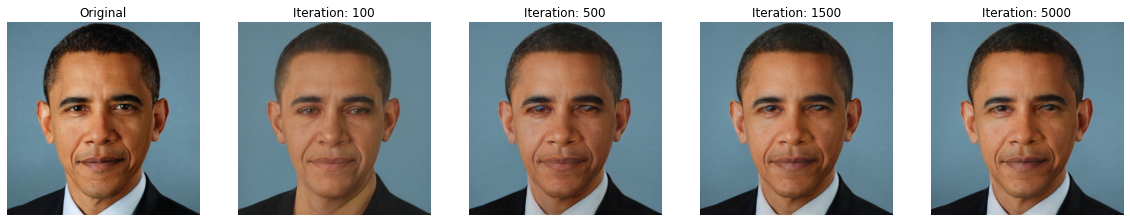

In [83]:
latent_codes = load_latents("sample03_latents_iters_005000_step_0100_loss_vgg16_w_mean.npz")
show_images_results(latent_codes, iterations_to_show = [100, 500, 1500, 5000], subfix = "_w_mean", save = True)

In [84]:
latent_codes = load_latents("sample03_latents_iters_005000_step_0100_loss_vgg16_w_zeros.npz")
show_images_results(latent_codes, iterations_to_show = [100, 500, 1500, 5000], subfix = "_w_zeros", save = True)

Saving: stuff/results/synthetic_images/images/sample03_images_100_to_5000_w_zeros.svg


Saving: stuff/results/synthetic_images/images/sample03_images_100_to_5000_w_random.svg


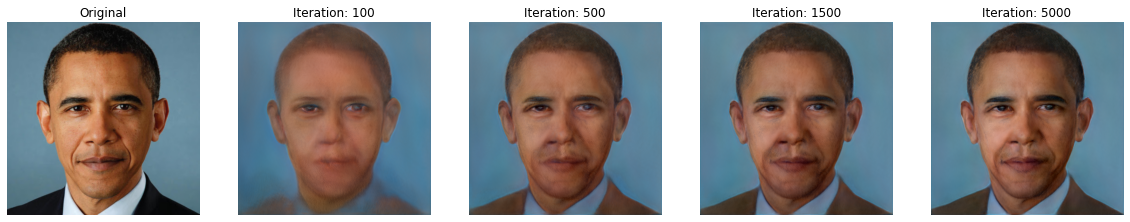

In [85]:
latent_codes = load_latents("sample03_latents_iters_005000_step_0100_loss_vgg16_w_random.npz")
show_images_results(latent_codes, iterations_to_show = [100, 500, 1500, 5000], subfix = "_w_random", save = True)

### Perceptual Losses Experiment

In this experiments, I want to check what is the effect of applied a different perceptual loss.

We need to define one the three options of perceptual loss:
1. `perceptual_lpips_alex`
2. `perceptual_lpips_vgg`
3. `perceptual_net_vgg`

Size:  torch.Size([1, 3, 1024, 1024])
Max:  tensor(1., device='cuda:0')
Min:  tensor(-1., device='cuda:0')


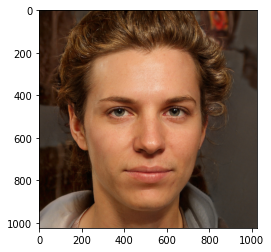

In [85]:
# Check the algorithm with other images
PATH_IMAGE = "stuff/data/sample04.png"
basename=os.path.basename(os.path.normpath(PATH_IMAGE)).split(".")[0]
SAVING_DIR = 'stuff/results/synthetic_images/'
img=lpips.im2tensor(lpips.load_image(PATH_IMAGE))
img=img.to(DEVICE)
print("Size: ", img.size())
print("Max: ", torch.max(img))
print("Min: ", torch.min(img))

# To plot the image I need to move to [0,1] interval
tmp_img = (img + 1.0) / 2.0
plt.imshow(tmp_img.to('cpu').squeeze(0).permute(1, 2, 0))

In [64]:
# I fixed the max iteration to 1500
ITERATIONS = 2000

In [65]:
# VGG-16 perceptual loss
loss_vgg16 = run_optimization(img, mode = 'vgg16', init = 'w_mean', normalization=True)

Starting Embedding
iter[100]:	 loss: 2.0905	 mse_loss: 0.0149	percep_loss: 2.0756
iter[200]:	 loss: 1.5230	 mse_loss: 0.0098	percep_loss: 1.5132
iter[300]:	 loss: 1.2374	 mse_loss: 0.0076	percep_loss: 1.2298
iter[400]:	 loss: 1.0970	 mse_loss: 0.0069	percep_loss: 1.0901
iter[500]:	 loss: 1.0088	 mse_loss: 0.0067	percep_loss: 1.0022
iter[600]:	 loss: 0.9480	 mse_loss: 0.0064	percep_loss: 0.9417
iter[700]:	 loss: 0.8932	 mse_loss: 0.0062	percep_loss: 0.8870
iter[800]:	 loss: 0.8546	 mse_loss: 0.0061	percep_loss: 0.8486
iter[900]:	 loss: 0.8084	 mse_loss: 0.0060	percep_loss: 0.8024
iter[1000]:	 loss: 0.7689	 mse_loss: 0.0058	percep_loss: 0.7630
iter[1100]:	 loss: 0.7373	 mse_loss: 0.0056	percep_loss: 0.7317
iter[1200]:	 loss: 0.7021	 mse_loss: 0.0054	percep_loss: 0.6967
iter[1300]:	 loss: 0.6789	 mse_loss: 0.0054	percep_loss: 0.6735
iter[1400]:	 loss: 0.6647	 mse_loss: 0.0053	percep_loss: 0.6594
iter[1500]:	 loss: 0.6592	 mse_loss: 0.0052	percep_loss: 0.6540
iter[1600]:	 loss: 0.6386	 mse

In [76]:
# LPIPS perceptual loss with vgg16
loss_lpips_vgg16 = run_optimization(img, mode = 'lpips_vgg16', init = 'w_mean', normalization=True)

Starting Embedding
iter[100]:	 loss: 0.2259	 mse_loss: 0.0092	percep_loss: 0.2166
iter[200]:	 loss: 0.2067	 mse_loss: 0.0078	percep_loss: 0.1990
iter[300]:	 loss: 0.1958	 mse_loss: 0.0070	percep_loss: 0.1888
iter[400]:	 loss: 0.1880	 mse_loss: 0.0064	percep_loss: 0.1816
iter[500]:	 loss: 0.1816	 mse_loss: 0.0060	percep_loss: 0.1755
iter[600]:	 loss: 0.1773	 mse_loss: 0.0059	percep_loss: 0.1715
iter[700]:	 loss: 0.1734	 mse_loss: 0.0056	percep_loss: 0.1678
iter[800]:	 loss: 0.1703	 mse_loss: 0.0055	percep_loss: 0.1648
iter[900]:	 loss: 0.1678	 mse_loss: 0.0053	percep_loss: 0.1625
iter[1000]:	 loss: 0.1657	 mse_loss: 0.0053	percep_loss: 0.1604
iter[1100]:	 loss: 0.1643	 mse_loss: 0.0052	percep_loss: 0.1590
iter[1200]:	 loss: 0.1631	 mse_loss: 0.0052	percep_loss: 0.1579
iter[1300]:	 loss: 0.1627	 mse_loss: 0.0051	percep_loss: 0.1575
iter[1400]:	 loss: 0.1611	 mse_loss: 0.0051	percep_loss: 0.1561
iter[1500]:	 loss: 0.1603	 mse_loss: 0.0050	percep_loss: 0.1552
iter[1600]:	 loss: 0.1601	 mse

In [86]:
# LPIPS perceptual loss with alexnet
loss_lpips_alex = run_optimization(img, mode = 'lpips_alex', init = 'w_mean', normalization=True)

Starting Embedding
iter[100]:	 loss: 0.1575	 mse_loss: 0.0071	percep_loss: 0.1504
iter[200]:	 loss: 0.1264	 mse_loss: 0.0043	percep_loss: 0.1220
iter[300]:	 loss: 0.1112	 mse_loss: 0.0039	percep_loss: 0.1073
iter[400]:	 loss: 0.1038	 mse_loss: 0.0037	percep_loss: 0.1002
iter[500]:	 loss: 0.0984	 mse_loss: 0.0035	percep_loss: 0.0949
iter[600]:	 loss: 0.0948	 mse_loss: 0.0034	percep_loss: 0.0914
iter[700]:	 loss: 0.0931	 mse_loss: 0.0034	percep_loss: 0.0897
iter[800]:	 loss: 0.0901	 mse_loss: 0.0033	percep_loss: 0.0869
iter[900]:	 loss: 0.0888	 mse_loss: 0.0032	percep_loss: 0.0856
iter[1000]:	 loss: 0.0874	 mse_loss: 0.0032	percep_loss: 0.0842
iter[1100]:	 loss: 0.0865	 mse_loss: 0.0032	percep_loss: 0.0833
iter[1200]:	 loss: 0.0858	 mse_loss: 0.0032	percep_loss: 0.0827
iter[1300]:	 loss: 0.0849	 mse_loss: 0.0032	percep_loss: 0.0818
iter[1400]:	 loss: 0.0841	 mse_loss: 0.0031	percep_loss: 0.0810
iter[1500]:	 loss: 0.0836	 mse_loss: 0.0031	percep_loss: 0.0805
iter[1600]:	 loss: 0.0828	 mse

In [55]:
losses = {
    "Perceptual VGG16 Loss": loss_vgg16_w_mean, 
    "Perceptual LPIPS VGG16 Loss" : loss_lpips_vgg16, 
    "Perceptual LPIPS AlexNet Loss" : loss_lpips_alex
    }
plot_loss(losses)

Saving: stuff/results/synthetic_images/images/sample03_images_5000_to_5000_vgg16.svg


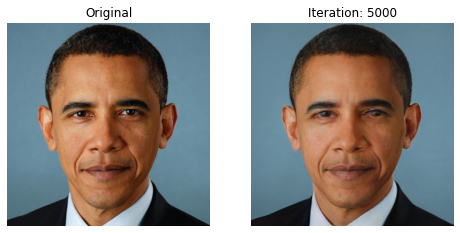

In [82]:
latent_codes = load_latents("sample03_latents_iters_005000_step_0100_loss_vgg16_w_mean.npz")
show_images_results(latent_codes, iterations_to_show = [5000], save = True,subfix="_vgg16")

Saving: stuff/results/synthetic_images/images/sample03_images_5000_to_5000_lpips_vgg16.svg


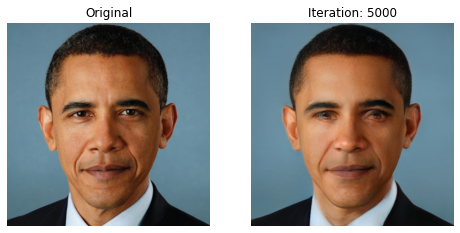

In [83]:
latent_codes = load_latents("sample03_latents_iters_005000_step_0100_loss_lpips_vgg16_w_mean.npz")
show_images_results(latent_codes, iterations_to_show = [5000], save = True,subfix="_lpips_vgg16")

Saving: stuff/results/synthetic_images/images/sample03_images_5000_to_5000_lpips_alex.svg


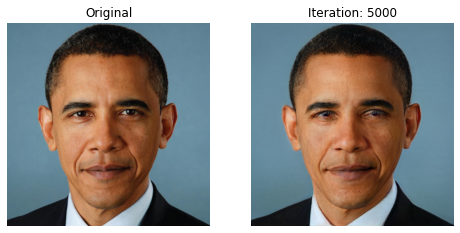

In [84]:
latent_codes = load_latents("sample03_latents_iters_005000_step_0100_loss_lpips_alex_w_mean.npz")
show_images_results(latent_codes, iterations_to_show = [5000], save = True,subfix="_lpips_alex")

Saving: stuff/results/synthetic_images/images/sample05_images_2000_to_2000_vgg16.svg


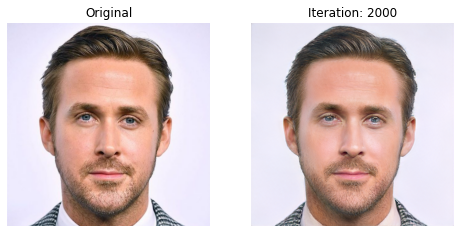

In [68]:
latent_codes = load_latents("sample05_latents_iters_002000_step_0100_loss_vgg16_w_mean.npz")
show_images_results(latent_codes, iterations_to_show = [2000], save = True,subfix="_vgg16")

Saving: stuff/results/synthetic_images/images/sample05_images_2000_to_2000_lpips_vgg16.svg


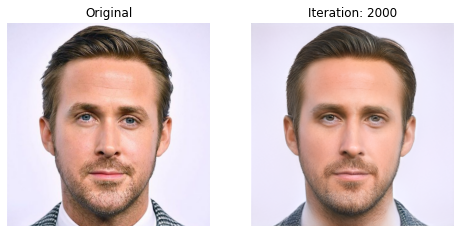

In [78]:
latent_codes = load_latents("sample05_latents_iters_002000_step_0100_loss_lpips_vgg16_w_mean.npz")
show_images_results(latent_codes, iterations_to_show = [2000], save = True,subfix="_lpips_vgg16")

Saving: stuff/results/synthetic_images/images/sample05_images_2000_to_2000_lpips_alex.svg


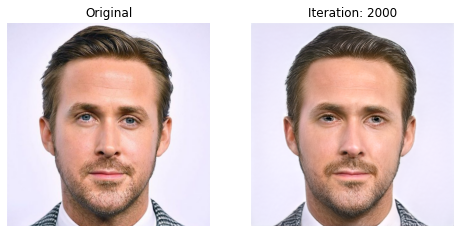

In [80]:
latent_codes = load_latents("sample05_latents_iters_002000_step_0100_loss_lpips_alex_w_zeros.npz")
show_images_results(latent_codes, iterations_to_show = [2000], save = True,subfix="_lpips_alex")

Saving: stuff/results/synthetic_images/images/sample04_images_2000_to_2000_lpips_alex.svg


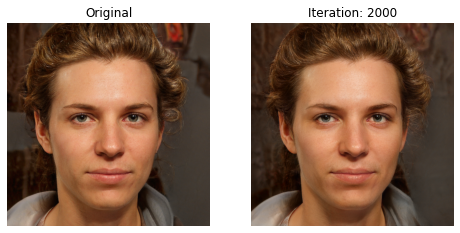

In [87]:
latent_codes = load_latents("sample04_latents_iters_002000_step_0100_loss_lpips_alex_w_mean.npz")
show_images_results(latent_codes, iterations_to_show = [2000], save = True,subfix="_lpips_alex")

Other results

In [ ]:
latent_codes = load_latents("sample05_latents_iters_005000_step_0100.npz")
show_images_results(latent_codes, iterations_to_show = [100, 200, 700 , 1000, 1500, 5000]) #, save = True)

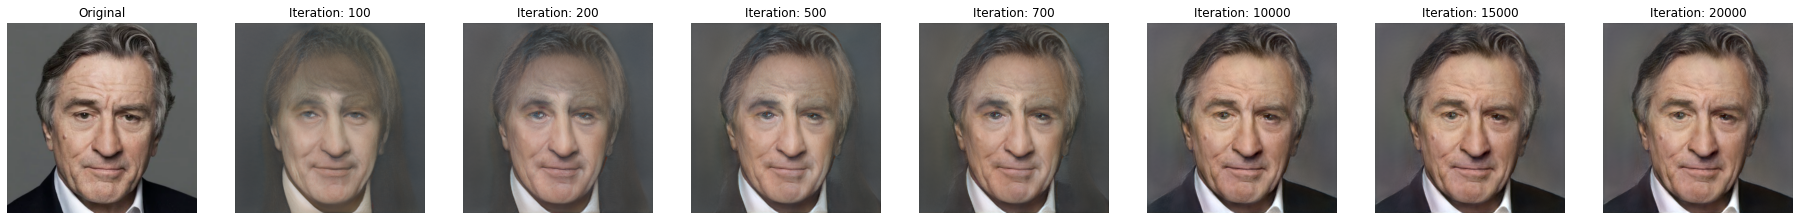

In [ ]:
latent_codes = load_latents("sample08_latents_iters_020000_step_0100.npz")
show_images_results(latent_codes, iterations_to_show = [100, 200, 500, 700 , 10000, 15000, 20000]) #, save = True)


In [ ]:
latent_codes = load_latents("expression01_latents_iters_002000_step_0100.npz")
show_images_results(latent_codes, iterations_to_show = [100, 200, 500, 700 , 1000, 1500, 2000]) #, save = True)


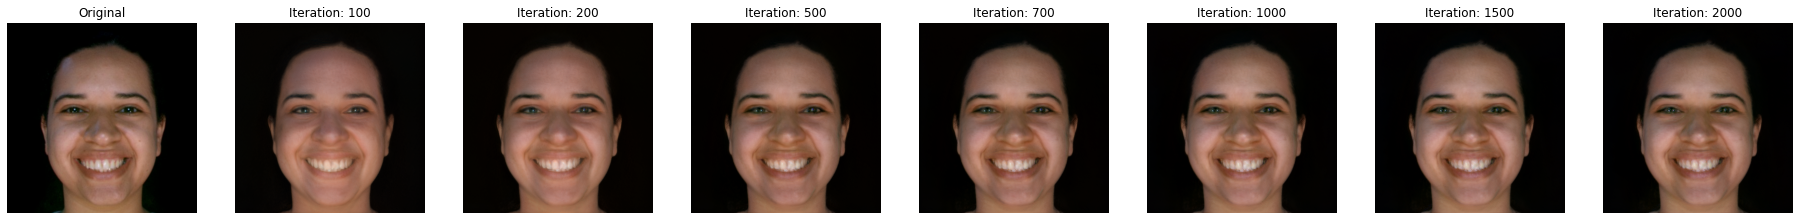

In [ ]:
latent_codes = load_latents("expression02_latents_iters_002000_step_0100.npz")
show_images_results(latent_codes, iterations_to_show = [100, 200, 500, 700 , 1000, 1500, 2000]) #, save = True)